In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.tsa.api as smt
import seaborn as sns
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.dates as mdates
sns.set(rc={'figure.figsize':(11, 4)})

read data and keep the data from Dec,31 2012.

,Energy_Generated,Efficiency,Energy_Exported,Energy_Used,Peak_Power,Peak_Time,Condition,Min_Temperature,Max_Temperature,Peak_Energy_Import,Off-Peak_Energy_Import,Shoulder_Energy_Import,High-Shoulder_Energy_Import,Insolation
Date,,,,,,,,,,,,,,
2019-04-25,3144,2.911,2977,0,984,13:20,Partly Cloudy,9,22,NaN,NaN,NaN,NaN,6308
2019-04-26,2715,2.514,2399,0,985,16:40,Partly Cloudy,3,17,NaN,NaN,NaN,NaN,6315
2019-04-27,2477,2.294,2049,0,1041,15:40,Partly Cloudy,7,20,NaN,NaN,NaN,NaN,6323
2019-04-28,3788,3.507,3693,0,963,13:00,Fine,7,21,NaN,NaN,NaN,NaN,6330
2019-04-29,3265,3.023,2706,0,1010,13:50,Partly Cloudy,3,24,NaN,NaN,NaN,NaN,6336


2259


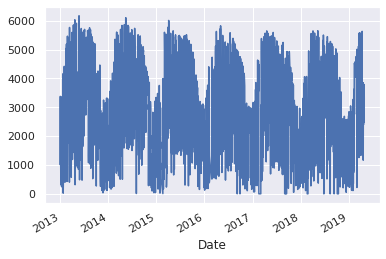

In [2]:
data = pd.read_pickle("../DATA_COLLECTOR/AGGREGATION_PRODUCTION/aggreg_PRODUCTION_data.pkl")
data.Date = pd.to_datetime(data['Date'],format='%Y%m%d')
data = data.sort_values(by='Date')
data = data[data.Date > '2012-12-31']
data = data.set_index('Date')

display(data.tail())
print(len(data))


data.Energy_Generated = pd.to_numeric(data.Energy_Generated)
data.Energy_Generated.plot()

Split data into train and test

In [3]:
thresh_date = '2018-12-31' #'2019-02-07', '2019-08-31'
train_data = data[data.index < thresh_date]
test_data = data[data.index > thresh_date]
display(train_data.head(2))
display(test_data.head(2))

print("Train size %d, test size %d" % (len(train_data), len(test_data)))

,Energy_Generated,Efficiency,Energy_Exported,Energy_Used,Peak_Power,Peak_Time,Condition,Min_Temperature,Max_Temperature,Peak_Energy_Import,Off-Peak_Energy_Import,Shoulder_Energy_Import,High-Shoulder_Energy_Import,Insolation
Date,,,,,,,,,,,,,,
2013-01-01,1013,0.938,998,0,807,13:10,Showers,8,13,NaN,NaN,NaN,NaN,3458
2013-01-02,2878,2.665,2840,0,837,13:00,Mostly Cloudy,7,13,NaN,NaN,NaN,NaN,3472


,Energy_Generated,Efficiency,Energy_Exported,Energy_Used,Peak_Power,Peak_Time,Condition,Min_Temperature,Max_Temperature,Peak_Energy_Import,Off-Peak_Energy_Import,Shoulder_Energy_Import,High-Shoulder_Energy_Import,Insolation
Date,,,,,,,,,,,,,,
2019-01-01,2022,1.872,1637,0,744,13:05,Fine,-2,9,NaN,NaN,NaN,NaN,3243
2019-01-02,277,0.256,88,0,116,14:40,Showers,2,4,NaN,NaN,NaN,NaN,3255


Train size 2139, test size 119


get daily production from MA with a window of 28 day ; resample the data weekly,monthly

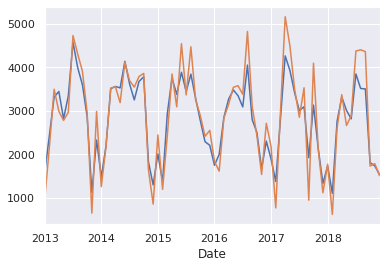

In [6]:
monthly_data_mean = train_data.Energy_Generated.resample('M').mean()
monthly_data_median = train_data.Energy_Generated.resample('M').median()
monthly_data_mean.plot(label='monthly mean')
monthly_data_median.plot(label='monthly median')
plt.legend()

weekly_data_mean = train_data.Energy_Generated.resample('W').mean()

Text(0.5, 1.0, 'Trends in Generated Energy')

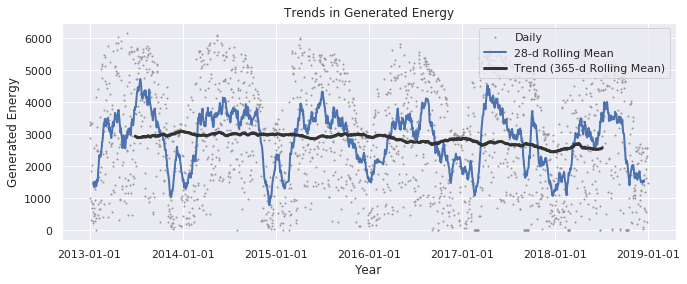

In [12]:
rolling_data_28day = train_data.Energy_Generated.rolling(28, center=True).mean()
rolling_data_365day = train_data.Energy_Generated.rolling(window=365, center=True, min_periods=360).mean()
rolling_data_28day = rolling_data_28day.dropna()


# Plot daily, 28-day rolling mean, and 365-day rolling mean time series
fig, ax = plt.subplots()
ax.plot(train_data.Energy_Generated, marker='.', markersize=2, color='0.6',
linestyle='None', label='Daily')
ax.plot(rolling_data_28day, linewidth=2, label='28-d Rolling Mean')
ax.plot(rolling_data_365day, color='0.2', linewidth=3,
label='Trend (365-d Rolling Mean)')
# Set x-ticks to yearly interval and add legend and labels
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.legend()
ax.set_xlabel('Year')
ax.set_ylabel('Generated Energy')
ax.set_title('Trends in Generated Energy')

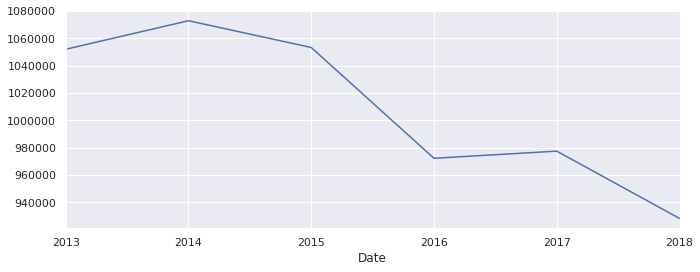

In [13]:
annual_data_sum = train_data.Energy_Generated.resample('A').sum()
annual_data_sum.plot()

<Figure size 792x288 with 0 Axes>

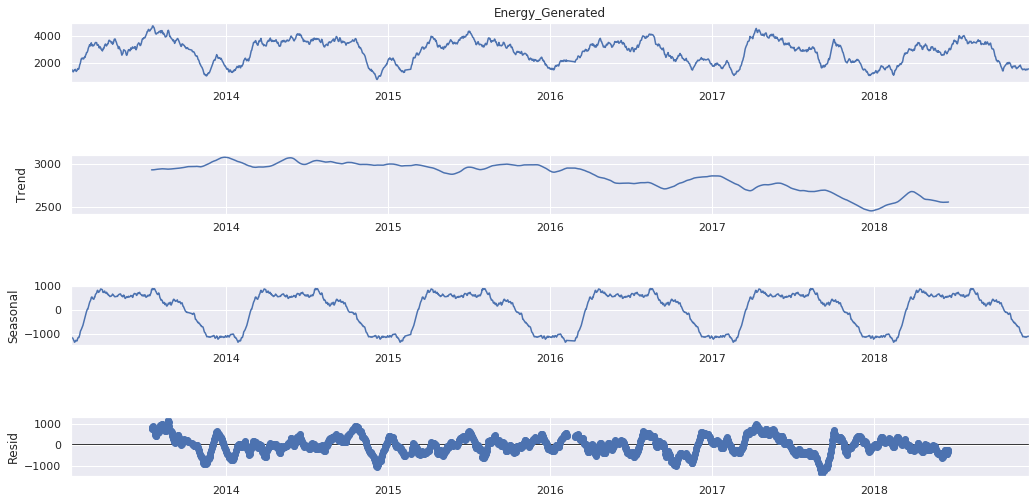

In [14]:
decomposition = seasonal_decompose(rolling_data_28day,period=360) 
fig = plt.figure()  
fig = decomposition.plot()  
fig.set_size_inches(15, 8)

<Figure size 792x288 with 0 Axes>

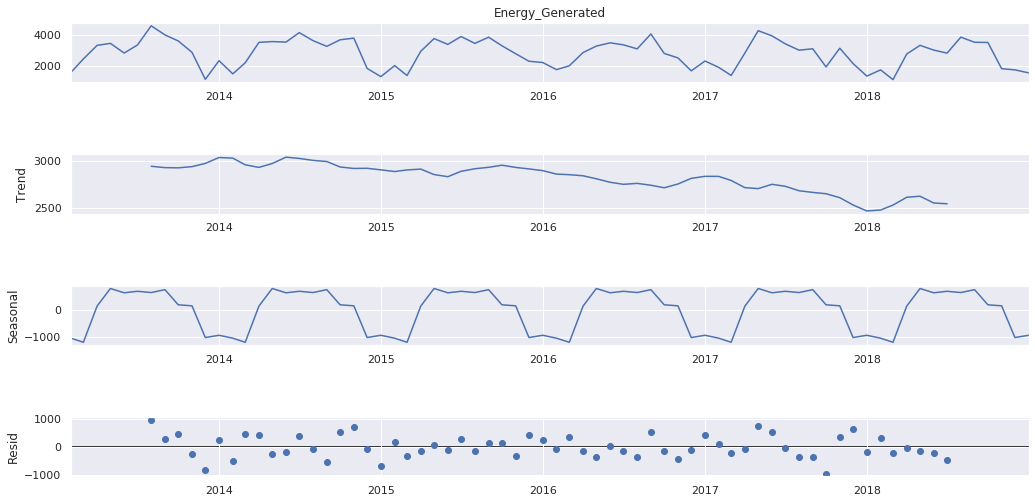

In [15]:
decomposition = seasonal_decompose(monthly_data_mean,period=12) 
fig = plt.figure()  
fig = decomposition.plot()  
fig.set_size_inches(15, 8)

<Figure size 792x288 with 0 Axes>

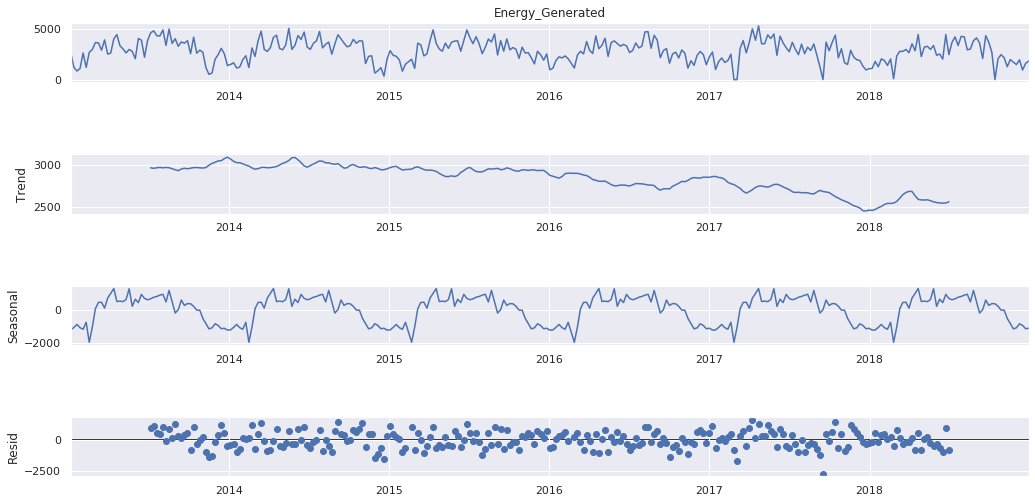

In [17]:
weekly_data_mean =weekly_data_mean.dropna()
decomposition = seasonal_decompose(weekly_data_mean,period=52) 
fig = plt.figure()  
fig = decomposition.plot()  
fig.set_size_inches(15, 8)

SARIMA on weekly mean production and monthly mean production

In [18]:
from statsmodels.tsa.stattools import adfuller

def test_stationarity(timeseries):  
    #Determing rolling statistics
    rolmean = timeseries.rolling(12, center=True).mean()
    rolstd = timeseries.rolling(12).std()

    #Plot rolling statistics:
    fig  = plt.figure(figsize=(12, 8))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std  = plt.plot(rolstd, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

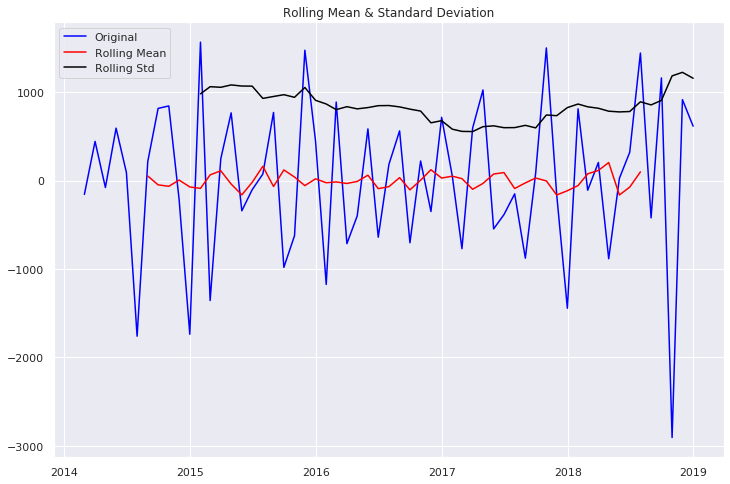

Results of Dickey-Fuller Test:
Test Statistic                -6.572223e+00
p-value                        7.883918e-09
#Lags Used                     4.000000e+00
Number of Observations Used    5.400000e+01
Critical Value (1%)           -3.557709e+00
Critical Value (5%)           -2.916770e+00
Critical Value (10%)          -2.596222e+00
dtype: float64


In [19]:
monthly_data_mean_first_diff = monthly_data_mean - monthly_data_mean.shift(1)  
monthly_data_mean_seasonal_first_difference = monthly_data_mean_first_diff - monthly_data_mean_first_diff.shift(12)
test_stationarity(monthly_data_mean_seasonal_first_difference.dropna(inplace=False))

Autocorrelation study to check the s,p,d,q order

/home/zhe/.local/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1406: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


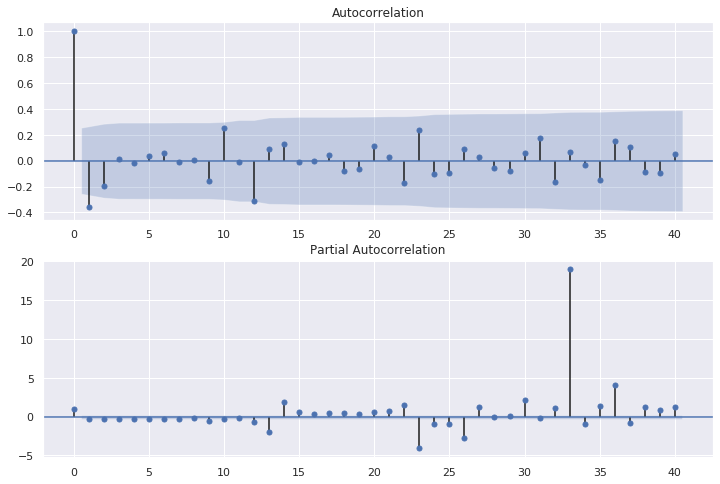

In [20]:
import statsmodels.api as sm 

fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(monthly_data_mean_seasonal_first_difference.iloc[13:], lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(monthly_data_mean_seasonal_first_difference.iloc[13:], lags=40, ax=ax2)

In [41]:
mod = sm.tsa.statespace.SARIMAX(monthly_data_mean, trend='n', order=(0,1,2), seasonal_order=(0,1,2,12))
results = mod.fit()
print(results.summary())

/home/zhe/.local/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/zhe/.local/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:868: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  ' zeros.' % warning_description)


                                     SARIMAX Results                                      
Dep. Variable:                   Energy_Generated   No. Observations:                   72
Model:             SARIMAX(0, 1, 2)x(0, 1, 2, 12)   Log Likelihood                -455.328
Date:                            Mon, 30 Mar 2020   AIC                            920.657
Time:                                    00:46:32   BIC                            931.044
Sample:                                01-31-2013   HQIC                           924.712
                                     - 12-31-2018                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.9909      0.284     -3.494      0.000      -1.547      -0.435
ma.L2         -0.0087      0.143   

Residual analyse

count      72.000000
mean      -57.932071
std       671.208091
min     -1947.235905
25%      -532.840146
50%       -23.419828
75%       395.287090
max      1567.161290
dtype: float64


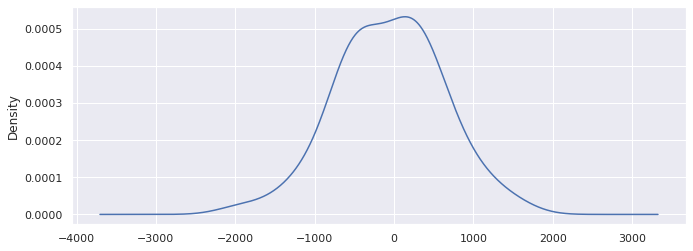

In [27]:
residuals = results.resid
#residuals.plot()
residuals.plot(kind='kde')
print(residuals.describe())

prediction for monthly data

In [28]:
test_monthly_data_mean = test_data.Energy_Generated.resample('M').mean()
M_test_size = len(test_monthly_data_mean)
print(M_test_size)

4


2019-01-31    1516.087373
2019-02-28    1408.186813
2019-03-31    2708.067011
2019-04-30    3381.473331
2019-05-31    3168.042104
Freq: M, dtype: float64


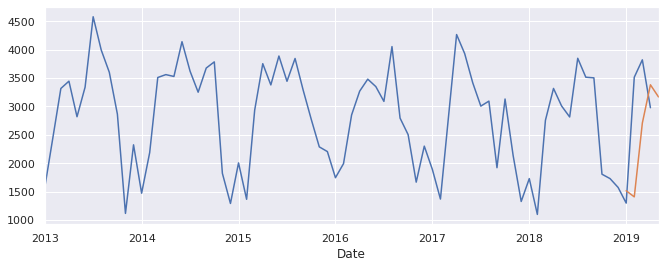

In [39]:
end   = M_test_size + monthly_data_mean.shape[0]
start = monthly_data_mean.shape[0]
forecast_values = results.predict(start=start, end=end, dynamic=True)
all_monthly_data_mean = data.Energy_Generated.resample('M').mean()
all_monthly_data_mean.plot()
forecast_values.plot()

print(forecast_values)